In [35]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline
from os import listdir
from PIL import Image
import glob
import os
import scipy.misc #to save failed images in 3 channel images
from skimage.feature import hog
import pickle
from scipy.ndimage.measurements import label


# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#Parameters to tweak
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

#the following parameters will be adjusted based on scales
x_start_stop = [550, 1280] 
y_start_stop = [350, 700] 

#set up rolling_heatmap parameters
rolling_heatmap_size = 15 #each second of video is composed of roughly 26 frames, so 15 would be near half
rolling_heatmap_threshold = 12 #more than half within the last 14 and current frame should have the heats spotted in labled positions

icount = 0

In [ ]:
#Load Udacity lecture functions
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one and undistort them
        #image = undistort(mpimg.imread(file),mtx,dist)
        image = mpimg.imread(file)
        #if images are not in .png (i.e. jpg), remove the following line
        #image = (image*255).astype(dtype=np.uint8)
        #image = adaptive_equalize_image(image, 2.0)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size      
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

#functions from Multiple Detections & False Positives on udacity lecture
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    #print("before threshold {}".format(sum(sum(heatmap))))    
    heatmap[heatmap <= threshold] = 0
    #print("after threshold {}".format(sum(sum(heatmap))))
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1): #for 3 cars detected, this will be from 1 to 3 inclusive
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
#         if ((car_number == 1) and (labels[1] == 3)):
#             print("found 2 total and displaying box poits for carnumber 1")
#             print(np.min(nonzerox))
#             print(np.max(nonzerox))
#             print(np.min(nonzeroy))
#             print(np.max(nonzeroy))
#             #cv2.putText(img,"{}".format(car_number), bbox[0], cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)        
#         cv2.putText(img,"{}".format(car_number), bbox[0], cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    # Return the image
    return img

def adaptive_equalize_image(img, level):
    """
    Adaptive Histogram Equalization : http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
    """
    clahe = cv2.createCLAHE(clipLimit=level, tileGridSize=(8, 8))
    if img.shape[2] == 3:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        cl = clahe.apply(l)
        result = cv2.merge((cl, a, b))
        result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB) 
    else:
        result = clahe.apply(img)
    return result


In [3]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, x_start_stop, y_start_stop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False, cells_per_step = 1.5):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    #remove the following line for processing png images.  frames sampled from mp4 files are in jpg format
    img = img.astype(np.float32)/255
    
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],x_start_stop[0]:x_start_stop[1],:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    #cells_per_step = 1.5  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(int(nxsteps)):
        for yb in range(int(nysteps)):
            ypos = int(yb*cells_per_step)
            xpos = int(xb*cells_per_step)
            
            #define blank arrays for all 3 potential features
            hog_features = []
            spatial_features = []
            hist_features = []

            if(hog_feat):            
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                if hog_channel == 'ALL':
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else:
                    hog_features = hog_feat1
    
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell                                   
            
            if(hist_feat or spatial_feat):            
                # Extract the image patch if hist_feat or spatial_feat is turned on
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                if(hist_feat):
                    hist_features = color_hist(subimg, nbins=hist_bins)
                if(spatial_feat):
                    spatial_features = bin_spatial(subimg, size=spatial_size)         

            # Scale features and make a prediction
            combined = np.hstack((spatial_features, hist_features, hog_features))
            test_features = X_scaler.transform(combined.reshape(1, -1))  
            
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #adjust for x_start_stop as well
                rectangles.append(((xbox_left+x_start_stop[0], ytop_draw+y_start_stop[0]),(xbox_left+win_draw+x_start_stop[0],ytop_draw+win_draw+y_start_stop[0])))
                
    return rectangles

In [4]:
car_images = glob.glob('./data/vehicles/**/*.png')
noncar_images = glob.glob('./data/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


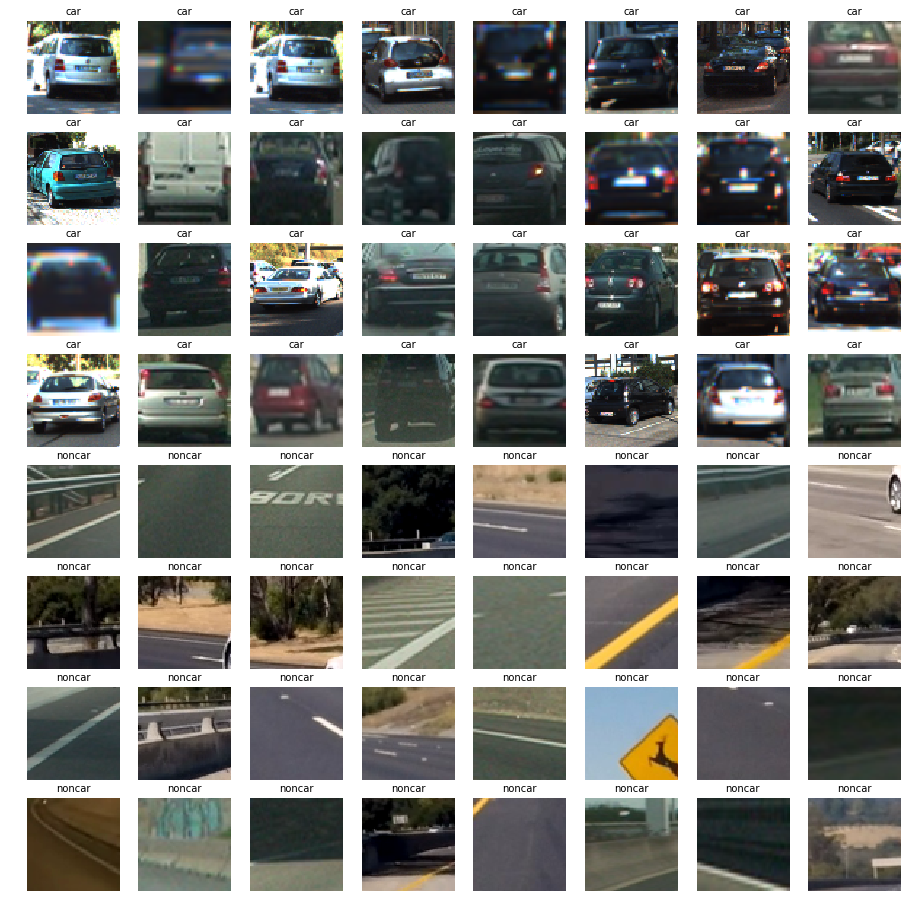

In [10]:

fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('noncar', fontsize=10)
    axs[i].imshow(img)
    
plt.savefig('./output_images/carsnoncars.png')

In [ ]:
#explore color spaces
img = mpimg.imread('./failed_images/toomany0.jpg')
print(img.shape)

img = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
plt.figure()
plt.imshow(img[:,:,0], cmap='gray')
img = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
plt.figure()
plt.imshow(img[:,:,1], cmap='gray')
img = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
plt.figure()
plt.imshow(img[:,:,2], cmap='gray')

img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
plt.figure()
plt.imshow(img[:,:,0], cmap='gray')
img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
plt.figure()
plt.imshow(img[:,:,1], cmap='gray')
img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
plt.figure()
plt.imshow(img[:,:,2], cmap='gray')

img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
plt.figure()
plt.imshow(img[:,:,0], cmap='gray')
img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
plt.figure()
plt.imshow(img[:,:,1], cmap='gray')
img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
plt.figure()
plt.imshow(img[:,:,2], cmap='gray')

# img = mpimg.imread('./data/vehicles/GTI_Right/image0039.png')
# plt.figure()
# plt.imshow(img)

# img = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
# plt.figure()
# plt.imshow(img)

# img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
# plt.figure()
# plt.imshow(img[:,:,1])


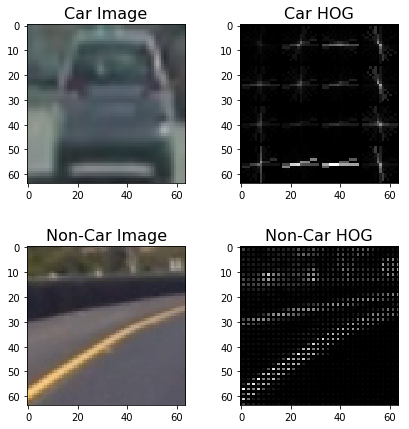

In [19]:
#HOG explore
car_img = mpimg.imread(car_images[5])
car_imgconv = cv2.cvtColor(car_img,cv2.COLOR_RGB2YUV)
_, car_dst = get_hog_features(car_imgconv[:,:,0], 12, 16, 2, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[5])
noncar_imgconv = cv2.cvtColor(noncar_img,cv2.COLOR_RGB2YUV)
_, noncar_dst = get_hog_features(noncar_imgconv[:,:,0], 12, 2, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
plt.savefig('./output_images/hogexplore.png')

In [5]:
#test
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(noncar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)       

In [6]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


Using: 12 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4368
29.53 Seconds to train SVC...
Test Accuracy of SVC =  0.9873


In [ ]:
#test CLAHE on sample car image that is dark overall
hogch = 0
car_img = mpimg.imread('./data/vehicles/GTI_Right/image0038.png')
car_img = (car_img*255).astype(dtype=np.uint8)
noncar_img = mpimg.imread('./data/non-vehicles/GTI/image63.png')
noncar_img = (noncar_img*255).astype(dtype=np.uint8)

_, car_dst = get_hog_features(car_img[:,:,hogch], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, noncar_dst = get_hog_features(noncar_img[:,:,hogch], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Visualize 
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(21,7))
f.subplots_adjust(hspace = 2, wspace=0.5)
ax1.imshow(car_img)
ax1.set_title('Okay Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Okay Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Okay Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Okay Non-Car HOG', fontsize=16)


car_img = adaptive_equalize_image(car_img, 2.0)
noncar_img = adaptive_equalize_image(noncar_img, 2.0)

_, car_dst = get_hog_features(car_img[:,:,hogch], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, noncar_dst = get_hog_features(noncar_img[:,:,hogch], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Visualize 
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(21,7))
f.subplots_adjust(hspace = 2, wspace=0.5)
ax1.imshow(car_img)
ax1.set_title('CLAHE Okay Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('CLAHE Okay Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('CLAHE Okay Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('CLAHE Okay Non-Car HOG', fontsize=16)



car_img = mpimg.imread('./data/vehicles/GTI_Right/image0069.png')
car_img = (car_img*255).astype(dtype=np.uint8)
noncar_img = mpimg.imread('./data/non-vehicles/GTI/image67.png')
noncar_img = (noncar_img*255).astype(dtype=np.uint8)

_, car_dst = get_hog_features(car_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, noncar_dst = get_hog_features(noncar_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Visualize 
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(21,7))
f.subplots_adjust(hspace = 2, wspace=0.5)
ax1.imshow(car_img)
ax1.set_title('Dark Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Dark Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Dark Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Dark Non-Car HOG', fontsize=16)


car_img = adaptive_equalize_image(car_img, 2.0)
print(car_img)
noncar_img = adaptive_equalize_image(noncar_img, 2.0)

_, car_dst = get_hog_features(car_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, noncar_dst = get_hog_features(noncar_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Visualize 
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(21,7))
f.subplots_adjust(hspace = 2, wspace=0.5)
ax1.imshow(car_img)
ax1.set_title('CLAHE Dark Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('CLAHE Dark Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('CLAHE Dark Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('CLAHE Dark Non-Car HOG', fontsize=16)


143 rectangles found in image


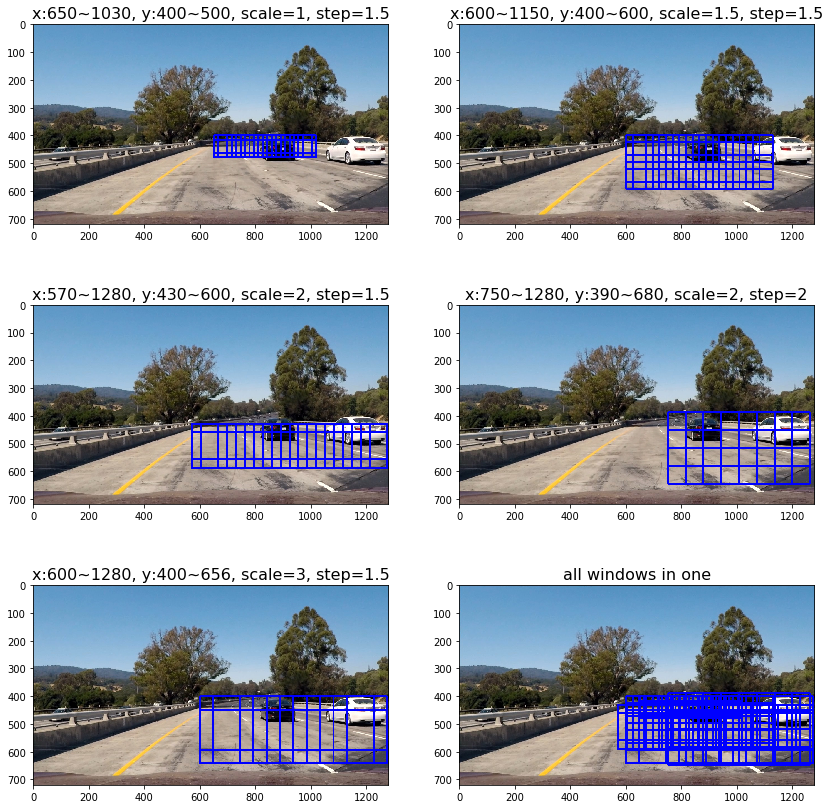

In [18]:
#test window selections
image = mpimg.imread('./test_images/test1.jpg')

# Visualize 
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,14))
f.subplots_adjust(hspace = .4, wspace=.2)

hot_windows = []

x_start_stop = [650,1030]
y_start_stop = [400,500]
scale = 1
cells_per_step = 1.5
hot_windows_temp = (find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True,cells_per_step=cells_per_step))
hot_windows.extend(hot_windows_temp)
window_img = draw_boxes(np.copy(image), hot_windows_temp, color=(0, 0, 255), thick=6)     
ax1.imshow(window_img)
ax1.set_title('x:650~1030, y:400~500, scale=1, step=1.5', fontsize=16)

x_start_stop = [600,1150]
y_start_stop = [400,600]
scale = 1.5
cells_per_step = 1.5
hot_windows_temp = (find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True,cells_per_step=cells_per_step))
hot_windows.extend(hot_windows_temp)
window_img = draw_boxes(np.copy(image), hot_windows_temp, color=(0, 0, 255), thick=6)     
ax2.imshow(window_img)
ax2.set_title('x:600~1150, y:400~600, scale=1.5, step=1.5', fontsize=16)

x_start_stop = [570,1280]
y_start_stop = [430,600]
scale = 2
cells_per_step = 1.5
hot_windows_temp = (find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True,cells_per_step=cells_per_step))
hot_windows.extend(hot_windows_temp)
window_img = draw_boxes(np.copy(image), hot_windows_temp, color=(0, 0, 255), thick=6)     
ax3.imshow(window_img)
ax3.set_title('x:570~1280, y:430~600, scale=2, step=1.5', fontsize=16)

x_start_stop = [750,1280]
y_start_stop = [390,680]
scale = 2
cells_per_step = 2
hot_windows_temp = (find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True,cells_per_step=cells_per_step))
hot_windows.extend(hot_windows_temp)
window_img = draw_boxes(np.copy(image), hot_windows_temp, color=(0, 0, 255), thick=6)     
ax4.imshow(window_img)
ax4.set_title('x:750~1280, y:390~680, scale=2, step=2', fontsize=16)

x_start_stop = [600,1280]
y_start_stop = [400,656]
scale = 3
cells_per_step = 1.5
hot_windows_temp = (find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True,cells_per_step=cells_per_step))
hot_windows.extend(hot_windows_temp)
window_img = draw_boxes(np.copy(image), hot_windows_temp, color=(0, 0, 255), thick=6)     
ax5.imshow(window_img)
ax5.set_title('x:600~1280, y:400~656, scale=3, step=1.5', fontsize=16)

window_img = draw_boxes(np.copy(image), hot_windows, color=(0, 0, 255), thick=6)     
ax6.imshow(window_img)
ax6.set_title('all windows in one', fontsize=16)

plt.savefig('./output_images/windows.png')

print(len(hot_windows), 'rectangles found in image')







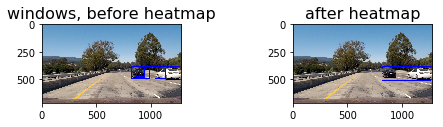

In [32]:
#test window selections
image = mpimg.imread('./test_images/test1.jpg')

# Visualize 
plt.figure()
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(7,2))
f.subplots_adjust(hspace = 1.6, wspace=.8)

hot_windows = []

x_start_stop = [650,1030]
y_start_stop = [400,500]
scale = 1
cells_per_step = 1.5
hot_windows.extend(find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,cells_per_step=cells_per_step))

x_start_stop = [600,1150]
y_start_stop = [400,600]
scale = 1.5
cells_per_step = 1.5
hot_windows.extend(find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,cells_per_step=cells_per_step))

x_start_stop = [570,1280]
y_start_stop = [430,600]
scale = 2
cells_per_step = 1.5
hot_windows.extend(find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,cells_per_step=cells_per_step))

x_start_stop = [750,1280]
y_start_stop = [390,680]
scale = 2
cells_per_step = 2
hot_windows.extend(find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,cells_per_step=cells_per_step))

x_start_stop = [600,1280]
y_start_stop = [400,656]
scale = 3
cells_per_step = 1.5
hot_windows.extend(find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,cells_per_step=cells_per_step))

window_img = draw_boxes(np.copy(image), hot_windows, color=(0, 0, 255), thick=6)  

box_list = hot_windows

heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,box_list)

heat_thres = apply_threshold(heat, 0.9) #non-filtering applied for writeup
# Visualize the heatmap when displaying    
heatmap = np.clip(heat_thres, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)

#for debugging
#print(labels[1])
draw_img = draw_labeled_bboxes(np.copy(image), labels)

ax1.imshow(window_img)
ax1.set_title('windows, before heatmap', fontsize=16)
ax2.imshow(draw_img)
ax2.set_title('after heatmap', fontsize=16)

plt.savefig('./output_images/pipeline.png')

In [36]:
#set up rolling_heatmap global array
image = mpimg.imread('./test_images/test6.jpg') #load any image from which sizes will be extracted from
rolling_heatmap = []

for i in range(rolling_heatmap_size):
    rolling_heatmap.append(np.zeros_like(image[:,:,0]).astype(np.float))

def process_frame(image):
    global rolling_heatmap
    
    hot_windows = []

    x_start_stop = [650,1030]
    y_start_stop = [400,500]
    scale = 1
    cells_per_step = 1.5
    hot_windows.extend(find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,cells_per_step=cells_per_step))

    x_start_stop = [600,1150]
    y_start_stop = [400,600]
    scale = 1.5
    cells_per_step = 1.5
    hot_windows.extend(find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,cells_per_step=cells_per_step))

    x_start_stop = [570,1280]
    y_start_stop = [430,600]
    scale = 2
    cells_per_step = 1.5
    hot_windows.extend(find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,cells_per_step=cells_per_step))

    x_start_stop = [750,1280]
    y_start_stop = [390,680]
    scale = 2
    cells_per_step = 2
    hot_windows.extend(find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,cells_per_step=cells_per_step))

    x_start_stop = [600,1280]
    y_start_stop = [400,656]
    scale = 3
    cells_per_step = 1.5
    hot_windows.extend(find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,cells_per_step=cells_per_step))

    box_list = hot_windows

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    #update the global rolling_heatmap list
    rolling_heatmap.append(rolling_heatmap.pop(0))
    rolling_heatmap[0] = heat

    # Apply threshold to help remove false positives
    sum_heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    for i in range(rolling_heatmap_size):       
        #print(sum(sum(rolling_heatmap[i])))
        sum_heatmap = sum_heatmap + rolling_heatmap[i]
#         #following lines are for debugging
#         plt.figure()
#         plt.imshow(heatmap, cmap='hot')
#         plt.title('Heat Map')
        #print(sum(sum(sum_heatmap)))
        #plt.figure()
        #plt.imshow(sum_heatmap, cmap='hot')
        #plt.title('Heat Map')

    #print(sum(sum(heat)))    
    #print(sum(sum(sum_heatmap)))
        
    heat_thres = apply_threshold(sum_heatmap, rolling_heatmap_threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_thres, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    #for debugging
    #print(labels[1])
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    #window_img = draw_boxes(np.copy(image), hot_windows, color=(0, 0, 255), thick=6)  
    #plt.figure()
    #plt.imshow(window_img)  
    #plt.title("count: {}".format(labels[1]))
    
    #debug too many windows found issues
    if(labels[1] > 2):
        #print("none")
        #plt.figure()
        #plt.imshow(draw_img)
        global icount
        scipy.misc.toimage(image).save("failed_images/toomany%s.jpg" %icount)
        icount = icount+1
        
#         #wrong lable test
#         nonzero = (labels[0] == 1).nonzero()
#         # Identify x and y values of those pixels
#         nonzeroy = np.array(nonzero[0])
#         nonzerox = np.array(nonzero[1])
#         # Define a bounding box based on min/max x and y
#         bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
#         # Draw the box on the image
#         t_img = cv2.rectangle(np.copy(image), bbox[0], bbox[1], (0,0,255), 6)  
        print(labels[1])
        #plt.figure()
        #plt.imshow(t_img)    
        
        #visualize heatmap for analysis
#         fig = plt.figure()
#         plt.subplot(141)
#         plt.imshow(draw_img)
#         plt.title('Car Positions')
#         plt.subplot(142)
#         plt.imshow(heatmap, cmap='hot')
#         plt.title('Heat Map')
#         plt.subplot(143)
#         plt.imshow(sum_heatmap, cmap='hot')
#         plt.title('Sum Heat Map')
#         plt.subplot(144)
#         plt.imshow(window_img)
#         plt.title('all detected windows Map')
#         fig.tight_layout()
    
    return draw_img
    

In [ ]:
#test on one image
image = mpimg.imread('failed_images/toomany5.jpg')
plt.figure()
plt.imshow(process_frame(image))

In [37]:
icount = 0
video_output = 'result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(37,50)
result_clip = clip1.fl_image(process_frame)
%time result_clip.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


 79%|██████████████████████████████▋        | 994/1261 [07:54<02:32,  1.75it/s]

3


 79%|██████████████████████████████▊        | 995/1261 [07:54<02:34,  1.72it/s]

3


 79%|██████████████████████████████▊        | 996/1261 [07:55<02:32,  1.74it/s]

3


 79%|██████████████████████████████▊        | 997/1261 [07:56<02:34,  1.71it/s]

3


 79%|██████████████████████████████▊        | 998/1261 [07:56<02:29,  1.76it/s]

3


 79%|██████████████████████████████▉        | 999/1261 [07:57<02:29,  1.76it/s]

3


 79%|██████████████████████████████▏       | 1000/1261 [07:57<02:28,  1.76it/s]

3


 79%|██████████████████████████████▏       | 1001/1261 [07:58<02:25,  1.78it/s]

3


 79%|██████████████████████████████▏       | 1002/1261 [07:58<02:23,  1.80it/s]

3


 80%|██████████████████████████████▏       | 1003/1261 [07:59<02:30,  1.71it/s]

3


 80%|██████████████████████████████▎       | 1006/1261 [08:01<02:20,  1.81it/s]

3


 80%|██████████████████████████████▎       | 1007/1261 [08:01<02:19,  1.83it/s]

3


 80%|██████████████████████████████▍       | 1008/1261 [08:02<02:16,  1.86it/s]

3


 80%|██████████████████████████████▍       | 1009/1261 [08:02<02:12,  1.90it/s]

3


 80%|██████████████████████████████▍       | 1010/1261 [08:03<02:11,  1.92it/s]

3


 80%|██████████████████████████████▍       | 1011/1261 [08:03<02:11,  1.89it/s]

3


 80%|██████████████████████████████▌       | 1014/1261 [08:05<02:03,  2.00it/s]

3


 81%|██████████████████████████████▌       | 1016/1261 [08:06<02:06,  1.94it/s]

3


 81%|██████████████████████████████▋       | 1017/1261 [08:06<02:07,  1.92it/s]

3


 81%|██████████████████████████████▊       | 1023/1261 [08:09<01:55,  2.07it/s]

3


 81%|██████████████████████████████▊       | 1024/1261 [08:10<02:03,  1.91it/s]

3


 81%|██████████████████████████████▉       | 1025/1261 [08:11<02:20,  1.68it/s]

3


 81%|██████████████████████████████▉       | 1026/1261 [08:11<02:26,  1.60it/s]

3


 81%|██████████████████████████████▉       | 1027/1261 [08:12<02:23,  1.63it/s]

3


 82%|██████████████████████████████▉       | 1028/1261 [08:12<02:16,  1.71it/s]

3


100%|█████████████████████████████████████▉| 1260/1261 [10:05<00:00,  2.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

Wall time: 10min 7s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))


In [ ]:
# icount = 0

def proc(image):
    
    hot_windows = []

    x_start_stop = [650,1030]
    y_start_stop = [400,500]
    scale = 1
    cells_per_step = 1.5
    hot_windows.extend(find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,cells_per_step=cells_per_step))

    x_start_stop = [600,1150]
    y_start_stop = [400,600]
    scale = 1.5
    cells_per_step = 1.5
    hot_windows.extend(find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,cells_per_step=cells_per_step))

    x_start_stop = [570,1280]
    y_start_stop = [430,600]
    scale = 2
    cells_per_step = 1.5
    hot_windows.extend(find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,cells_per_step=cells_per_step))

    x_start_stop = [750,1280]
    y_start_stop = [390,680]
    scale = 2
    cells_per_step = 2
    hot_windows.extend(find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,cells_per_step=cells_per_step))

    x_start_stop = [600,1280]
    y_start_stop = [400,656]
    scale = 3
    cells_per_step = 1.5
    hot_windows.extend(find_cars(image, x_start_stop, y_start_stop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,cells_per_step=cells_per_step))
      
    
    #for debugging


    draw_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6) 
    
#     if(len(hot_windows) == 0):
#         #print("none")
#         #plt.figure()
#         #plt.imshow(draw_img)
#         global icount
#         scipy.misc.toimage(image).save("failed_images/failed%s.jpg" %icount)
#         icount = icount+1
#     else:
#         print(len(hot_windows))
    return draw_img

In [ ]:
#test on one image
image = mpimg.imread('failed_images/toomany1.jpg')
plt.figure()
plt.imshow(proc(image))

In [ ]:

video_output = 'resultnomapfail.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("project_video.mp4").subclip(40,42)
result_clip = clip1.fl_image(proc)
%time result_clip.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))